# Description

## SFC Requests Placed

Compute the requests placed

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the Results folder inside the docker container
path_results = "../logs"

# hue_order = ["Random", "Greedy", "Speed"]

hue_order = ["Domain", "Auction", "Speed"]

hue_label = ["Single Domain", "Auction", "SPEED"]

# hue_order = ["Random", "Domain", "Auction", "Speed"]

def connect_dataframe(pda, num_requests, label, rnd):
    global hue_order
    pda['Num_Requests'] = num_requests
    pda['Label'] = label
    pda['Round'] = rnd

    return pda

def load_data():

    num_requests = dict()

    experiments = list(filter(lambda x: os.path.isdir(os.path.join(path_results, x)), os.listdir(path_results)))

    requests = []
    data_aggregation = []
    for exp in experiments:
        aux = exp.split("_")
        num_requests[int(aux[0])] = int(aux[0])

        for alg in hue_order:
            # distributed placement            
            if alg == "Auction" or alg == "Domain" :
                
                exp_file = "{}/{}/{}/placement.csv".format(path_results, exp, alg.lower())
                
                proc_data = pd.read_csv(exp_file, sep=';')
                
                proc_data.replace("PLACEMENT_SUCCESS", "SUCCESS", inplace=True)                
                proc_data.replace("PLACEMENT_FAIL", "FAIL", inplace=True)            

                if alg == "Domain":
                    alg = "Single Domain"
                    
                requests.append(connect_dataframe(
                    proc_data,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))
                
            else:                
                exp_file = "{}/{}/{}/distributed_placement.csv".format(path_results, exp, alg.lower())
                
                exp_file2 = "{}/{}/{}/data_aggregation.csv".format(path_results, exp, alg.lower())
                
                proc_data1 = pd.read_csv(exp_file, sep=';')
                
                if alg == "Speed":
                    alg = "SPEED"
                    
                requests.append(connect_dataframe(
                    proc_data1,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))
        
                # data aggregation
                proc_data2 = pd.read_csv(exp_file2, sep=';')
                data_aggregation.append(connect_dataframe(
                    proc_data2,
                    int(aux[0]),
                    alg,
                    int(aux[1]),
                ))

    o = list(num_requests.keys())

    data = {
        'requests': requests,
        'data_aggregation': data_aggregation,
        'order': o
    }

    return data

# pd.set_option('display.max_rows', 20)
aux = load_data()
# display(aux)

# Process Data

Return the percentage of success placement

In [35]:
def process_data():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        # df = services.loc[(services['Event'] == "SUCCESS") | (services['Event'] == "FAIL")]
        services_processed.append(services)        

    res = pd.concat(services_processed)

    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).size().reset_index(name='Count')
    
    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).size().reset_index(name='Count')
    
    # grouped_data = res.groupby(['Label', 'Num_Requests', 'Round','Event']).count().reset_index()

    grouped_data = res.groupby(['Label', 'Num_Requests', 'Round'])["Event"].value_counts(normalize=True).mul(100).unstack("Event").fillna(0).reset_index()
  
    # grouped_data.loc[grouped_data['SUCCESS'] > 100, 'SUCCESS'] = grouped_data['SUCCESS'] * 1.5
    # 
    # grouped_data.loc[grouped_data['SUCCESS'] > 100, 'SUCCESS'] = 1  
    # display(grouped_data.loc[grouped_data['Label'] == 'Speed', 'SUCCESS'])
    #
    
    # grouped_data["percentage"] = (grouped_data['Count'] / grouped_data['Num_Requests'])
        
    return grouped_data

load_data()
df_summed = process_data()
df_summed

Event,Label,Num_Requests,Round,FAIL,SUCCESS
0,Auction,30,0,73.684211,26.315789
1,Auction,30,1,77.000000,23.000000
2,Auction,30,2,78.000000,22.000000
3,Auction,30,3,75.000000,25.000000
4,Auction,30,4,72.727273,27.272727
...,...,...,...,...,...
376,Single Domain,100,3,25.000000,75.000000
377,Single Domain,100,9,75.000000,25.000000
378,Single Domain,100,12,42.857143,57.142857
379,Single Domain,100,13,50.000000,50.000000


## Service Placed

Print the service success rate placement graph

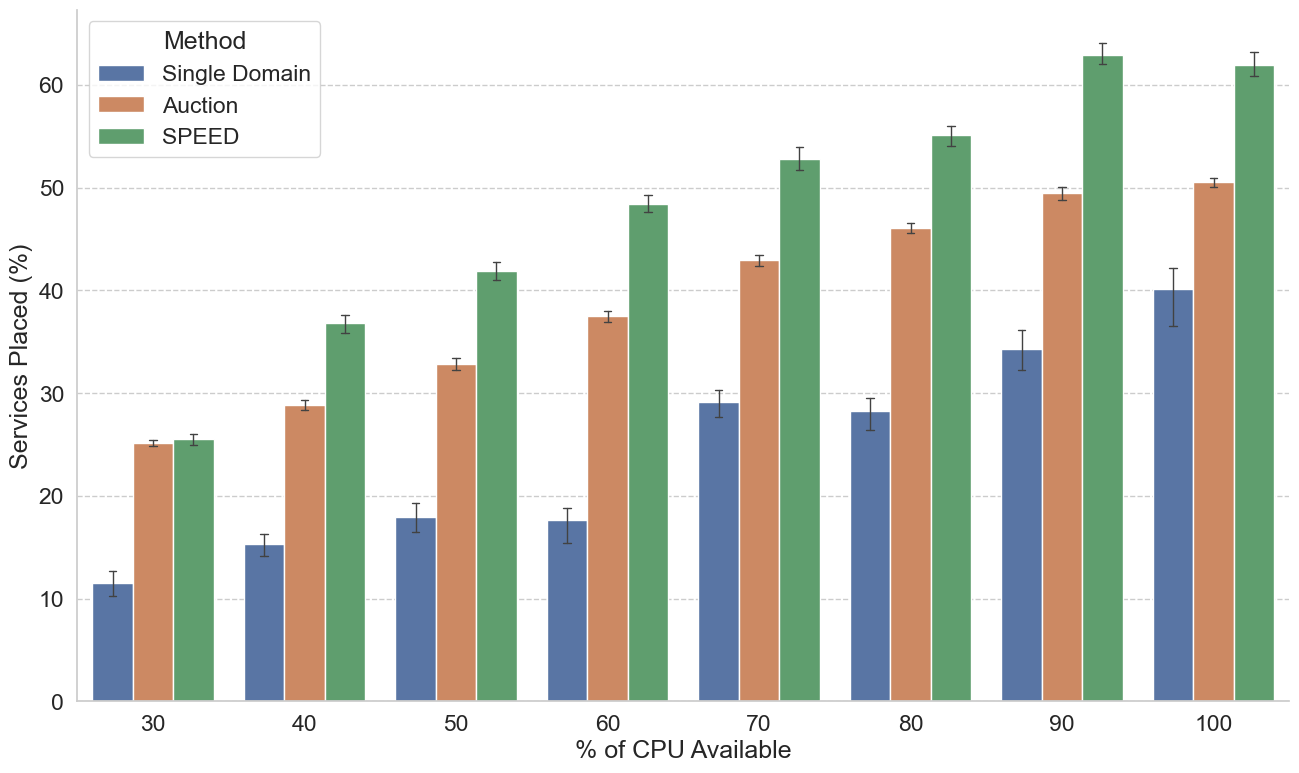

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_label,
    x="Num_Requests",
    y="SUCCESS",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 30),
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("% of CPU Available", "Services Placed (%)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./services_placed_cpu_load.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [31]:
def process_data_cost():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests','Round']).mean(['Cost']).reset_index()

    grouped_data["cost_dollar"] = (grouped_data['Cost'] / 1000)
    # grouped_data["cost_dollar"] = (grouped_data['Cost'] / 1)

    return grouped_data

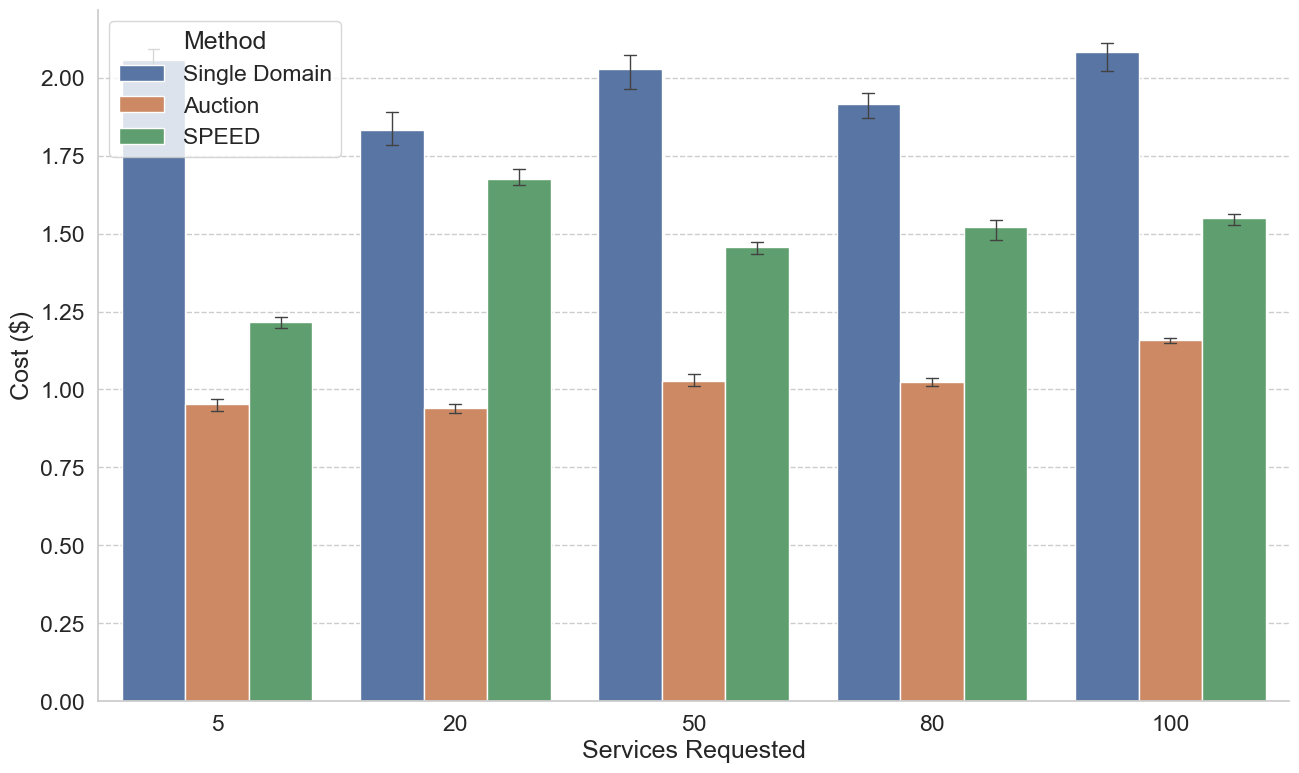

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_cost()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    order = order,
    hue_order=hue_label,
    x="Num_Requests",
    y="cost_dollar",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),    
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Cost ($)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./services_cost.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

In [96]:
def process_data_placement_time():
    data = load_data()

    entities = data['requests']

    services_processed = []

    for services in entities:
        df = services.loc[(services['Event'] == "SUCCESS") & (services['Label'] == "SPEED")]
        services_processed.append(df)

    res = pd.concat(services_processed)

    grouped_data = res.groupby(['Label', 'Num_Requests', 'Round'],  observed=True).mean(["Placement_Time"]).reset_index()
    
    return grouped_data

df_summed = process_data_placement_time()
df_summed.describe()

,Num_Requests,Round,Time,Cost,Placement_Time
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,51.000000,4.500000,2883.634776,1482.923581,30.055696
std,35.913729,2.901442,1040.019537,343.599814,5.880450
min,5.000000,0.000000,1476.600000,822.000000,20.200000
25%,20.000000,2.000000,2233.912589,1232.436805,26.582051
50%,50.000000,4.500000,2729.756579,1415.912791,29.394533
75%,80.000000,7.000000,3199.772727,1746.481763,34.371875
max,100.000000,9.000000,7556.600000,2289.787234,49.200000


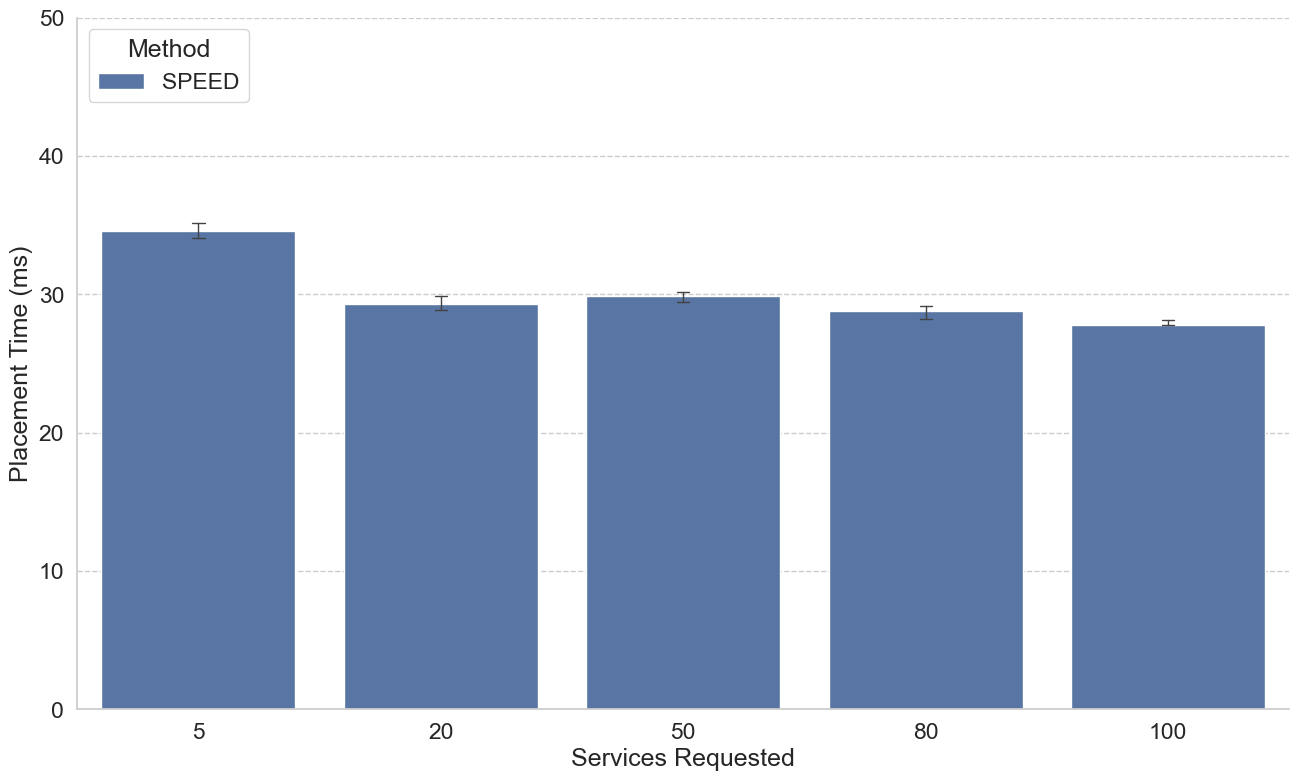

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_placement_time()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Placement_Time",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),  
    legend_out=False
)

g.set(ylim=(0, 50))

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Placement Time (ms)")
plt.legend(loc='upper left', title='Method')

plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./placement_time.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')

# Compute Aggregation Data Size

Compute the size of the data exchanged between the zones to execute the placement

In [98]:
def process_data_size():
    data = load_data()
    entities = data['data_aggregation']
    services_processed = []
    for services in entities:
        df = services.loc[(services['Label'] == "SPEED")]
        services_processed.append(df)

    gd = pd.concat(services_processed)

    gd = gd.groupby(['Label', 'Num_Requests', 'Round'],  observed=True).sum(["Size"]).reset_index()

    gd["Size"] = gd['Size'] / 100000000

    return gd

data = process_data_size()
data

,Label,Num_Requests,Round,Time,Size,Data
0,SPEED,5,0,30888396.0,0.673441,0.0
1,SPEED,5,1,9578844.0,0.624825,0.0
2,SPEED,5,2,17138616.0,0.601070,0.0
3,SPEED,5,3,12944052.0,0.484639,0.0
4,SPEED,5,4,7363356.0,0.642089,0.0
5,SPEED,5,5,11379192.0,0.648995,0.0
6,SPEED,5,6,33916212.0,0.626621,0.0
7,SPEED,5,7,12128688.0,0.558679,0.0
8,SPEED,5,8,14910192.0,0.628046,0.0
9,SPEED,5,9,19193196.0,0.556598,0.0


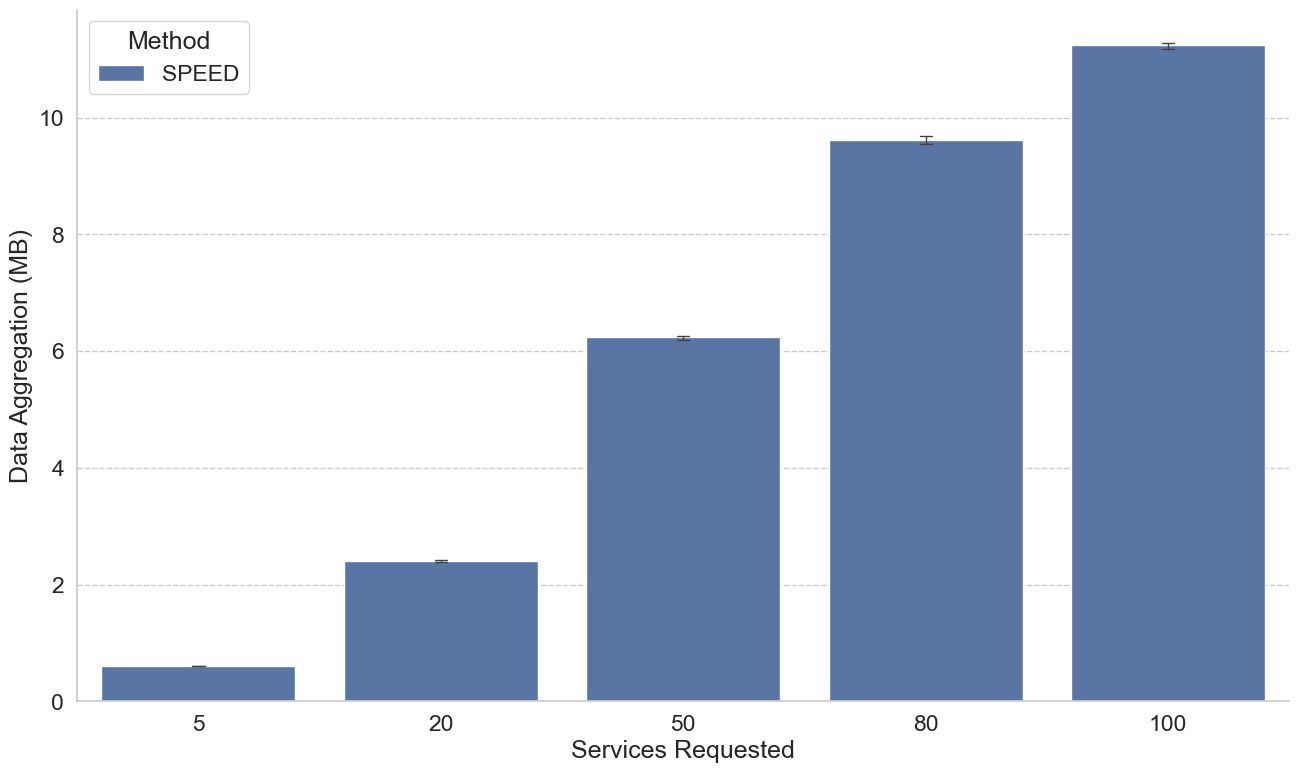

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.color_palette("rocket")

loaded_data = load_data()

order = sorted(loaded_data['order'])

df_summed = process_data_size()

g = sns.catplot(
    data=df_summed,
    kind="bar",
    hue="Label",
    x="Num_Requests",
    y="Size",
    capsize=.05,
    errwidth=1,
    errorbar=('ci', 20),  
    legend_out=False
)

g.fig.set_figheight(9)
g.fig.set_figwidth(16)

g.set_axis_labels("Services Requested", "Data Aggregation (MB)")
plt.legend(loc='upper left', title='Method')

plt.show()

g.figure.savefig(fname='./data_aggregation_size.pdf', transparent=False, pad_inches=0.3, bbox_inches='tight')